In [1]:
import numpy as np
import pandas as pd
import os
import math
from matplotlib import pyplot as plt
import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
class DictionarySizeIsNotSupported(Exception): pass
class StringsAreDifferentLength(Exception): pass
class OverlapSpecifiedIsNotSmallerThanWindowSize(Exception): pass


class SAX(object):
    """
    此类用于计算符号聚合近似法。简而言之，这就是
    将一系列数据转换为字符串，然后可以将其与其他字符串进行比较
    这样的字符串使用查找表。
    """

    def __init__(self, wordSize = 8, alphabetSize = 5, epsilon = 1e-6):

        if alphabetSize < 3 or alphabetSize > 20:
            raise DictionarySizeIsNotSupported()
        self.aOffset = ord('a')
        self.wordSize = wordSize
        self.alphabetSize = alphabetSize
        self.eps = epsilon
        self.breakpoints = {'3' : [-0.43, 0.43],
                            '4' : [-0.67, 0, 0.67],
                            '5' : [-0.84, -0.25, 0.25, 0.84],
                            '6' : [-0.97, -0.43, 0, 0.43, 0.97],
                            '7' : [-1.07, -0.57, -0.18, 0.18, 0.57, 1.07],
                            '8' : [-1.15, -0.67, -0.32, 0, 0.32, 0.67, 1.15],
                            '9' : [-1.22, -0.76, -0.43, -0.14, 0.14, 0.43, 0.76, 1.22],
                            '10': [-1.28, -0.84, -0.52, -0.25, 0, 0.25, 0.52, 0.84, 1.28],
                            '11': [-1.34, -0.91, -0.6, -0.35, -0.11, 0.11, 0.35, 0.6, 0.91, 1.34],
                            '12': [-1.38, -0.97, -0.67, -0.43, -0.21, 0, 0.21, 0.43, 0.67, 0.97, 1.38],
                            '13': [-1.43, -1.02, -0.74, -0.5, -0.29, -0.1, 0.1, 0.29, 0.5, 0.74, 1.02, 1.43],
                            '14': [-1.47, -1.07, -0.79, -0.57, -0.37, -0.18, 0, 0.18, 0.37, 0.57, 0.79, 1.07, 1.47],
                            '15': [-1.5, -1.11, -0.84, -0.62, -0.43, -0.25, -0.08, 0.08, 0.25, 0.43, 0.62, 0.84, 1.11, 1.5],
                            '16': [-1.53, -1.15, -0.89, -0.67, -0.49, -0.32, -0.16, 0, 0.16, 0.32, 0.49, 0.67, 0.89, 1.15, 1.53],
                            '17': [-1.56, -1.19, -0.93, -0.72, -0.54, -0.38, -0.22, -0.07, 0.07, 0.22, 0.38, 0.54, 0.72, 0.93, 1.19, 1.56],
                            '18': [-1.59, -1.22, -0.97, -0.76, -0.59, -0.43, -0.28, -0.14, 0, 0.14, 0.28, 0.43, 0.59, 0.76, 0.97, 1.22, 1.59],
                            '19': [-1.62, -1.25, -1, -0.8, -0.63, -0.48, -0.34, -0.2, -0.07, 0.07, 0.2, 0.34, 0.48, 0.63, 0.8, 1, 1.25, 1.62],
                            '20': [-1.64, -1.28, -1.04, -0.84, -0.67, -0.52, -0.39, -0.25, -0.13, 0, 0.13, 0.25, 0.39, 0.52, 0.67, 0.84, 1.04, 1.28, 1.64]
                            }
        self.beta = self.breakpoints[str(self.alphabetSize)]
        self.build_letter_compare_dict()
        self.scalingFactor = 1


    def to_letter_rep(self, x):
        """
        函数获取一系列数据 x，并将其转换为字符串表示形式
        """
        (paaX, indices) = self.to_PAA(self.normalize(x))
        self.scalingFactor = np.sqrt((len(x) * 1.0) / (self.wordSize * 1.0))
        return (self.alphabetize(paaX), indices)

    def normalize(self, x):
        """
        函数将规范化一个数组（给它一个平均值 0 和一个 1) 的标准差
        除非它的标准差低于epsilon，在这种情况下，它返回一个长度为零的数组的原始数组。
        """
        X = np.asanyarray(x)
        if np.nanstd(X) < self.eps:
            res = []
            for entry in X:
                if not np.isnan(entry):
                    res.append(0)
                else:
                    res.append(np.nan)
            return res
        return (X - np.nanmean(X)) / np.nanstd(X)

    def to_PAA(self, x):
        """
        函数对数据集执行分段聚合逼近，减少数据集 x 到 w 离散级别的维度。 
        返回减少的维度数据集，以及原始对应的索引和每个缩减维度的数据
        """
        n = len(x)
        stepFloat = n/float(self.wordSize)
        step = int(math.ceil(stepFloat))
        frameStart = 0
        approximation = []
        indices = []
        i = 0
        while frameStart <= n-step:
            thisFrame = np.array(x[frameStart:int(frameStart + step)])
            approximation.append(np.mean(thisFrame))
            indices.append((frameStart, int(frameStart + step)))
            i += 1
            frameStart = int(i*stepFloat)
        return (np.array(approximation), indices)

    def alphabetize(self,paaX):
        """
        将 x 的分段聚合近似转换为一系列字母
        """
        alphabetizedX = ''
        for i in range(0, len(paaX)):
            letterFound = False
            for j in range(0, len(self.beta)):
                if np.isnan(paaX[i]):
                    alphabetizedX += '-'
                    letterFound = True
                    break
                if paaX[i] < self.beta[j]:
                    alphabetizedX += chr(self.aOffset + j)
                    letterFound = True
                    break
            if not letterFound:
                alphabetizedX += chr(self.aOffset + len(self.beta))
        return alphabetizedX

    def compare_strings(self, sA, sB):
        """
        根据单个字母距离比较两个字符串
        要求两个字符串的长度相同
        """
        if len(sA) != len(sB):
            raise StringsAreDifferentLength()
        list_letters_a = [x for x in sA]
        list_letters_b = [x for x in sB]
        mindist = 0.0
        for i in range(0, len(list_letters_a)):
            if list_letters_a[i] != '-' and list_letters_b[i] != '-':
                mindist += self.compare_letters(list_letters_a[i], list_letters_b[i])**2
        mindist = self.scalingFactor* np.sqrt(mindist)
        return mindist

    def compare_letters(self, la, lb):
        """
        根据字母距离返回两个字母之间的距离比较两个字母
        """
        return self.compareDict[la+lb]

    def build_letter_compare_dict(self):
        """
        建立查找表以确定两个字母之间的数字距离
        给定字母大小。 将创建“ab”和“ba”的条目，其具有相同的值。
        """
        number_rep = range(0,self.alphabetSize)
        letters = [chr(x + self.aOffset) for x in number_rep]
        self.compareDict = {}
        for i in range(0, len(letters)):
            for j in range(0, len(letters)):
                if np.abs(number_rep[i]-number_rep[j]) <=1:
                    self.compareDict[letters[i]+letters[j]] = 0
                else:
                    high_num = np.max([number_rep[i], number_rep[j]])-1
                    low_num = np.min([number_rep[i], number_rep[j]])
                    self.compareDict[letters[i]+letters[j]] = self.beta[high_num] - self.beta[low_num]

    def sliding_window(self, x, numSubsequences = None, overlappingFraction = None):
        if not numSubsequences:
            numSubsequences = 20
        self.windowSize = int(len(x)/numSubsequences)
        if not overlappingFraction:
            overlappingFraction = 0.9
        overlap = self.windowSize*overlappingFraction
        moveSize = int(self.windowSize - overlap)
        if moveSize < 1:
            raise OverlapSpecifiedIsNotSmallerThanWindowSize()
        ptr = 0
        n = len(x)
        windowIndices = []
        stringRep = []
        while ptr < n-self.windowSize+1:
            thisSubRange = x[ptr:ptr+self.windowSize]
            (thisStringRep,indices) = self.to_letter_rep(thisSubRange)
            stringRep.append(thisStringRep)
            windowIndices.append((ptr, ptr+self.windowSize))
            ptr += moveSize
        return (stringRep,windowIndices)

    def batch_compare(self, xStrings, refString):
        return [self.compare_strings(x, refString) for x in xStrings]

    def set_scaling_factor(self, scalingFactor):
        self.scalingFactor = scalingFactor

    def set_window_size(self, windowSize):
        self.windowSize = windowSize

In [3]:
df = pd.read_excel('数据示例.xlsx',header=None)
df.rename(columns={0:'Date',1:'F1',2:'F2'},inplace=True)
df.set_index('Date',inplace=True)

In [12]:
279/31

9.0

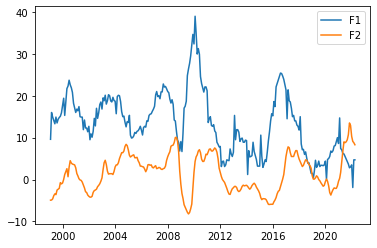

In [4]:
plt.plot(df.F1,label='F1')
plt.plot(df.F2,label='F2')
plt.legend()

In [5]:
from statsmodels.tsa import stattools
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import statsmodels.api as sm
import statsmodels

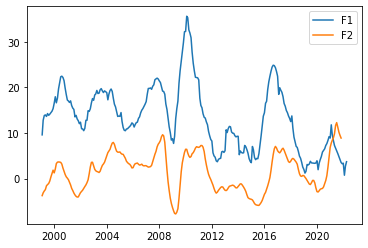

In [6]:
ses1 = SimpleExpSmoothing(np.asarray(df.F1)).fit(smoothing_level=0.5,optimized=False)
ses2 = SimpleExpSmoothing(np.asarray(df.F2)).fit(smoothing_level=0.5,optimized=False)
data = df.copy(deep=True)
data['F1'] = ses1.fittedfcast[1:]
data['F2'] = ses2.fittedfcast[1:]
plt.plot(data.F1,label='F1')
plt.plot(data.F2.shift(-5),label='F2')
plt.legend()

In [7]:
s = SAX(31,5)

In [13]:
(x1String, x1Indices) = s.to_letter_rep(df.F1)
(x2String, x2Indices) = s.to_letter_rep(df.F2)
(x3String, x3Indices) = s.to_letter_rep(df.F2.shift(-10))

x1x2ComparisonScore = s.compare_strings(x1String, x2String)
x1x3ComparisonScore = s.compare_strings(x1String, x3String)
x1x2ComparisonScore, x1x3ComparisonScore

(9.160272921698347, 6.120588207027163)

In [14]:
x1String

'cddccdddbcdedceecabbaacedbaaaba'

In [15]:
x2String

'acdbacceedddeabeecabbaabedcbbde'